# 1 Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from clearml import Task

from keras.layers import RandomFlip, RandomRotation, RandomCrop, RandomZoom, RandomContrast
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
task = Task.init(project_name='Architecture Style Classification', task_name='Imbalanced data with focal loss and weighted classes')

ClearML Task: overwriting (reusing) task id=91c386bcf5fd48438cf45fb419913fc6
2024-04-22 10:48:16,816 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/fb01ac3f8ec0442db15dd95b35c1dc10/experiments/91c386bcf5fd48438cf45fb419913fc6/output/log


# 1.1 Create the Dataset and Split it into Training and Validation Sets


In [ ]:
from pathlib import Path
import imghdr
from PIL import Image

data_dir = "D:/University/FinalDatasetSplited/train/21_st_Century, Blobitecture"
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [68]:
def is_image_corrupted(image_path):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        return False  
    except tf.errors.InvalidArgumentError:
        return True  

root_directory = 'D:/University/FinalDatasetSplited/test'
corrupted_images = []
for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, file)
            if is_image_corrupted(image_path):
                try:
                    print(image_path)
                    img = Image.open(image_path)

                    print("fail here")
                    img_format = 'JPEG'
                    img.save(image_path, format=img_format)

                    print(f"Header fixed for {image_path}")
                except Exception as e:
                    print(f"Failed to fix header for {image_path}: {e}")

for image_path in corrupted_images:
    print("Corrupted image:", image_path)

D:/University/FinalDatasetSplited/test\21_st_Century, Neo-futurism architecture\03116.jpg
Failed to fix header for D:/University/FinalDatasetSplited/test\21_st_Century, Neo-futurism architecture\03116.jpg: name 'Image' is not defined
D:/University/FinalDatasetSplited/test\Classical, Roman Classical architecture\2382.jpg
Failed to fix header for D:/University/FinalDatasetSplited/test\Classical, Roman Classical architecture\2382.jpg: name 'Image' is not defined
D:/University/FinalDatasetSplited/test\Early_Christian_Medieval, Medieval Architecture\3288.jpg
Failed to fix header for D:/University/FinalDatasetSplited/test\Early_Christian_Medieval, Medieval Architecture\3288.jpg: name 'Image' is not defined


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = 'D:/University/FinalDatasetSplited/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            validation_split=0.2,
                                                            label_mode='categorical',
                                                            subset='training',
                                                            seed=42)
validation_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=0.2,
                                                                 subset='validation',
                                                                 label_mode='categorical',
                                                                 seed=42)

Found 16292 files belonging to 51 classes.
Using 13034 files for training.
Found 16292 files belonging to 51 classes.
Using 3258 files for validation.


Represent data

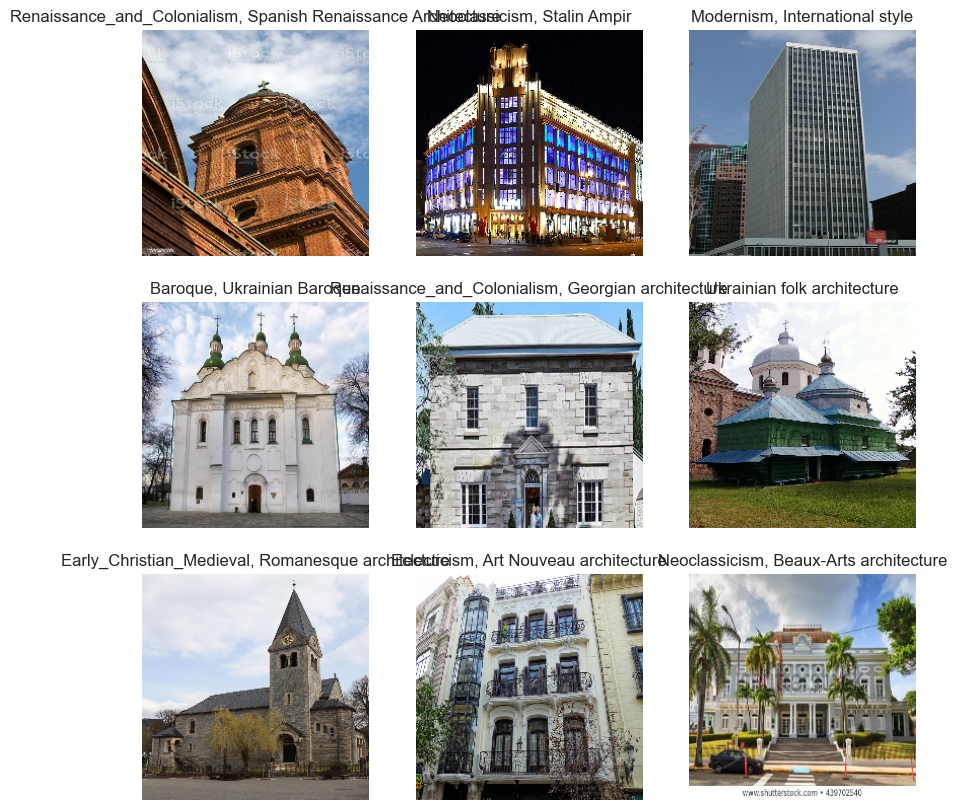

In [4]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy().astype("int")
        plt.title(class_names[np.where(label == 1)[0][0]])
        plt.axis("off")

In [5]:
class_labels = []
for images, labels in train_dataset:
    class_labels.extend(np.argmax(labels, axis=1))
class_labels = np.array(class_labels)

In [6]:
from sklearn.utils import compute_class_weight
unique_labels = np.unique(class_labels)
class_weights = compute_class_weight('balanced', classes=unique_labels, y=class_labels)
class_weight_dict = dict(zip(unique_labels, class_weights))
class_weight_dict

{0: 1.5679056898833152,
 1: 1.0182017029919537,
 2: 1.4603921568627451,
 3: 2.777919863597613,
 4: 1.1409313725490196,
 5: 2.8396514161220043,
 6: 0.7744503862150921,
 7: 2.808446455505279,
 8: 2.8715576118087687,
 9: 2.0445490196078433,
 10: 2.937570430471039,
 11: 0.7986519607843138,
 12: 0.9094968948433466,
 13: 0.8722478752593188,
 14: 2.4110247872734,
 15: 2.7188151856487277,
 16: 1.161675579322638,
 17: 0.16703831859541202,
 18: 2.9717282261741906,
 19: 1.7037908496732026,
 20: 0.2362002102134754,
 21: 2.8396514161220043,
 22: 0.9607843137254902,
 23: 0.9829562594268476,
 24: 0.5769043509051476,
 25: 0.6294793779580797,
 26: 1.0783486390336725,
 27: 1.026380029923616,
 28: 1.3106083459024636,
 29: 0.8722478752593188,
 30: 2.3663761801016703,
 31: 0.8406862745098039,
 32: 0.7001880204136449,
 33: 1.087526074259491,
 34: 1.2228163992869876,
 35: 0.9571858706029228,
 36: 0.7343926076177597,
 37: 2.3663761801016703,
 38: 0.9430576658707763,
 39: 2.607843137254902,
 40: 3.155168240135

# 2 Preprocess and Augment Training Data

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.1))
    data_augmentation.add(RandomZoom(0.2))
    data_augmentation.add(RandomCrop(height=IMG_SIZE[0], width=IMG_SIZE[1]))
    data_augmentation.add(RandomContrast(factor=0.2))
    return data_augmentation

Augumented images

In [9]:
data_augmentation = data_augmenter()



In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetV2B0(input_shape=IMG_SHAPE,
                                                    include_top=True,
                                                    weights='imagenet')

In [11]:

preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

# 3 Using EfficientNetB0V2

In [12]:
def arc_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape,
                                                        include_top=False,
                                                        weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)

    x = base_model(x, training=False)

    x = tf.keras.layers.GlobalMaxPooling2D()(x)

    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization(x)
    # x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    # x = tf.keras.layers.BatchNormalization(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization(x)
    # x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(51, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)

In [14]:
model2 = arc_model(IMG_SIZE, data_augmentation)
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.CategoricalFocalCrossentropy(),
               metrics=['accuracy'],
               )
initial_epochs = 50
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[learning_rate_reduction, early_stopping], class_weight=class_weight_dict)

Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.0507 - loss: 0.9492 - val_accuracy: 0.0319 - val_loss: 0.7143 - learning_rate: 0.0010
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 392s 946ms/step - accuracy: 0.1540 - loss: 0.6778 - val_accuracy: 0.1857 - val_loss: 0.5703 - learning_rate: 0.0010
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 382s 923ms/step - accuracy: 0.1926 - loss: 0.6250 - val_accuracy: 0.1041 - val_loss: 0.5713 - learning_rate: 0.0010
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 383s 926ms/step - accuracy: 0.2105 - loss: 0.5967 - val_accuracy: 0.2753 - val_loss: 0.4937 - learning_rate: 0.0010
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 380s 917ms/step - accuracy: 0.2366 - loss: 0.5705 - val_accuracy: 0.2753 - val_loss: 0.5105 - learning_rate: 0.0010
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.2572 - loss: 0.5571
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
408/408 ━━━━━━━━━━━━━━━━━━━━ 376s 909ms/step - accuracy: 0.

Results

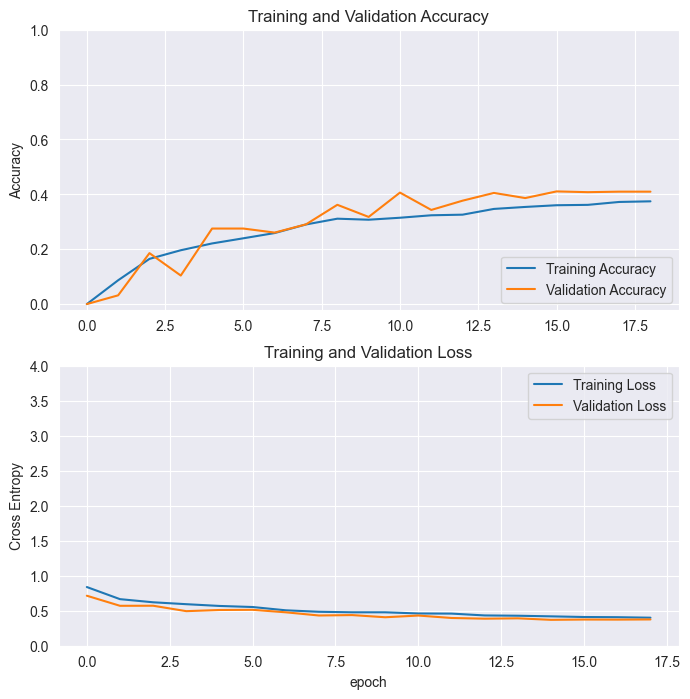

In [15]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss'][:25]
val_loss = history.history['val_loss'][:25]
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
from tensorflow.keras import layers

base_model = model2
model2.trainable = True

fine_tune_at = -10

# for layer in base_model.layers[:fine_tune_at]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = False
for layer in model2.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
loss_function = tf.keras.losses.CategoricalFocalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)

metrics = ['accuracy']

model2.compile(loss=loss_function,
               optimizer=optimizer,
               metrics=metrics)

fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                          epochs=total_epochs,
                          initial_epoch=history.epoch[-1],
                          validation_data=validation_dataset,
                          callbacks=[learning_rate_reduction, early_stopping],
                          class_weight=class_weight_dict
                          )

Epoch 18/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1160s 3s/step - accuracy: 0.2509 - loss: 0.5835 - val_accuracy: 0.3766 - val_loss: 0.4148 - learning_rate: 1.0000e-04
Epoch 19/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1097s 3s/step - accuracy: 0.3646 - loss: 0.4030 - val_accuracy: 0.4641 - val_loss: 0.3309 - learning_rate: 1.0000e-04
Epoch 20/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1099s 3s/step - accuracy: 0.4024 - loss: 0.3653 - val_accuracy: 0.4779 - val_loss: 0.3226 - learning_rate: 1.0000e-04
Epoch 21/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1100s 3s/step - accuracy: 0.4301 - loss: 0.3292 - val_accuracy: 0.5282 - val_loss: 0.2833 - learning_rate: 1.0000e-04
Epoch 22/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1100s 3s/step - accuracy: 0.4588 - loss: 0.3048 - val_accuracy: 0.5543 - val_loss: 0.2591 - learning_rate: 1.0000e-04
Epoch 23/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1100s 3s/step - accuracy: 0.4735 - loss: 0.2803 - val_accuracy: 0.5798 - val_loss: 0.2436 - learning_rate: 1.0000e-04
Epoch 24/100
408/408 ━━━━━━━━━━━━━━━━━━━

Results

In [58]:
acc

[0.0,
 0.20937548577785492,
 0.2850237786769867,
 0.30980512499809265,
 0.33435630798339844,
 0.3721037209033966,
 0.3856835961341858,
 0.3953506350517273,
 0.4047107696533203,
 0.408623605966568,
 0.4212060868740082,
 0.4229706823825836,
 0.4498235285282135,
 0.46025779843330383,
 0.4548105001449585,
 0.4740678369998932,
 0.4776737689971924,
 0.4780573844909668,
 0.48680374026298523,
 0.4894123077392578,
 0.48994937539100647,
 0.49056315422058105,
 0.49716126918792725,
 0.4913303554058075,
 0.49923276901245117,
 0.4112321734428406,
 0.5086696147918701,
 0.5400490760803223,
 0.5705845952033997,
 0.5904557108879089,
 0.611170768737793,
 0.6321160197257996,
 0.6514500379562378,
 0.6690194606781006,
 0.6810649037361145,
 0.7027006149291992,
 0.7160503268241882,
 0.7271750569343567,
 0.7465858459472656,
 0.7577105760574341,
 0.7686818838119507,
 0.7793463468551636,
 0.7914684414863586,
 0.7974528074264526,
 0.8089611530303955,
 0.8189350962638855,
 0.8291391730308533,
 0.846785306930542,
 

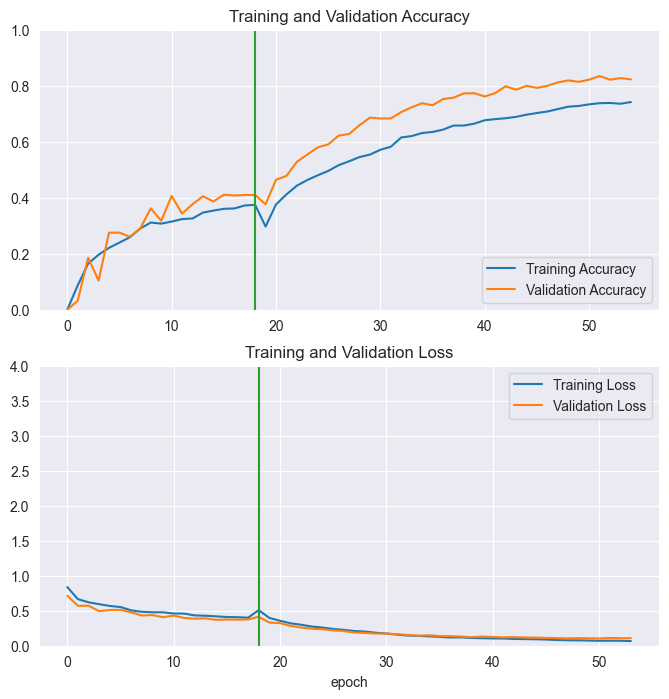

In [17]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([18, 18],
         plt.ylim())
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([18, 18],
         plt.ylim())
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [63]:
base_model = model2
base_model.trainable = True

fine_tune_at = -10

# for layer in base_model.layers[:fine_tune_at]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = False
for layer in base_model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)
metrics = ['accuracy']

base_model.compile(loss=loss_function,
               optimizer=optimizer,
               metrics=metrics)

fine_tune_epochs1 = 50
total_epochs = initial_epochs + fine_tune_epochs + fine_tune_epochs1

history_fine = base_model.fit(train_dataset,
                          epochs=total_epochs,
                          initial_epoch=history_fine.epoch[-1],
                          validation_data=validation_dataset,
                          callbacks=[learning_rate_reduction, early_stopping]
                          )

Epoch 50/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 1215s 3s/step - accuracy: 0.8369 - loss: 0.4532 - val_accuracy: 0.8122 - val_loss: 0.6455 - learning_rate: 1.0000e-04
Epoch 51/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 1128s 3s/step - accuracy: 0.8504 - loss: 0.4269 - val_accuracy: 0.8303 - val_loss: 0.6052 - learning_rate: 1.0000e-04
Epoch 52/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 1129s 3s/step - accuracy: 0.8574 - loss: 0.4116 - val_accuracy: 0.8174 - val_loss: 0.6465 - learning_rate: 1.0000e-04
Epoch 53/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8552 - loss: 0.4178
Epoch 53: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
408/408 ━━━━━━━━━━━━━━━━━━━━ 1127s 3s/step - accuracy: 0.8552 - loss: 0.4178 - val_accuracy: 0.8106 - val_loss: 0.6955 - learning_rate: 1.0000e-04
Epoch 54/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 1126s 3s/step - accuracy: 0.8788 - loss: 0.3484 - val_accuracy: 0.8171 - val_loss: 0.6475 - learning_rate: 5.0000e-05


# Evaluate the results

In [26]:
test_directory = 'D:/University/FinalDatasetSplited/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory,
                                                            shuffle=False,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical',
                                                            seed=42)
#test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

ValueError: `validation_split` must be between 0 and 1, received: 1

In [19]:
loss, accuracy = model2.evaluate(train_dataset, batch_size=BATCH_SIZE, verbose=0)
print('Train Loss:', loss, 'Train Accuracy:', accuracy)

Train Loss: 0.0507592037320137 Train Accuracy: 0.8121834993362427


In [20]:
loss, accuracy = model2.evaluate(validation_dataset, batch_size=BATCH_SIZE, verbose=0)
print('Validation Loss:', loss, 'Validation Accuracy:', accuracy)

Validation Loss: 0.1035703495144844 Validation Accuracy: 0.8345611095428467


In [21]:
loss, accuracy = model2.evaluate(test_dataset, batch_size=BATCH_SIZE, verbose=0)
print('Test Loss:', loss, 'Test Accuracy:', accuracy)

Test Loss: 0.29131996631622314 Test Accuracy: 0.5790929198265076


In [22]:
from sklearn.metrics import classification_report

prediction = model2.predict(test_dataset, batch_size=BATCH_SIZE, verbose=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 583ms/step


In [23]:
true_labels = []
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels, axis=1))

predicted_labels = np.argmax(prediction, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))

                                                                precision    recall  f1-score   support

                                   21_st_Century, Blobitecture       0.46      0.52      0.49        23
                               21_st_Century, Deconstructivism       0.58      0.76      0.66        34
                               21_st_Century, Eco-architecture       0.89      0.64      0.74        25
                      21_st_Century, Neo-futurism architecture       0.36      0.36      0.36        11
                        21_st_Century, Postmodern architecture       0.49      0.53      0.51        32
                          Baroque, Andean Baroque Architecture       0.46      0.50      0.48        12
                                 Baroque, Baroque architecture       0.54      0.54      0.54        46
                      Baroque, Earthquake Baroque Architecture       0.35      0.46      0.40        13
                                  Baroque, Rococo Architecture 

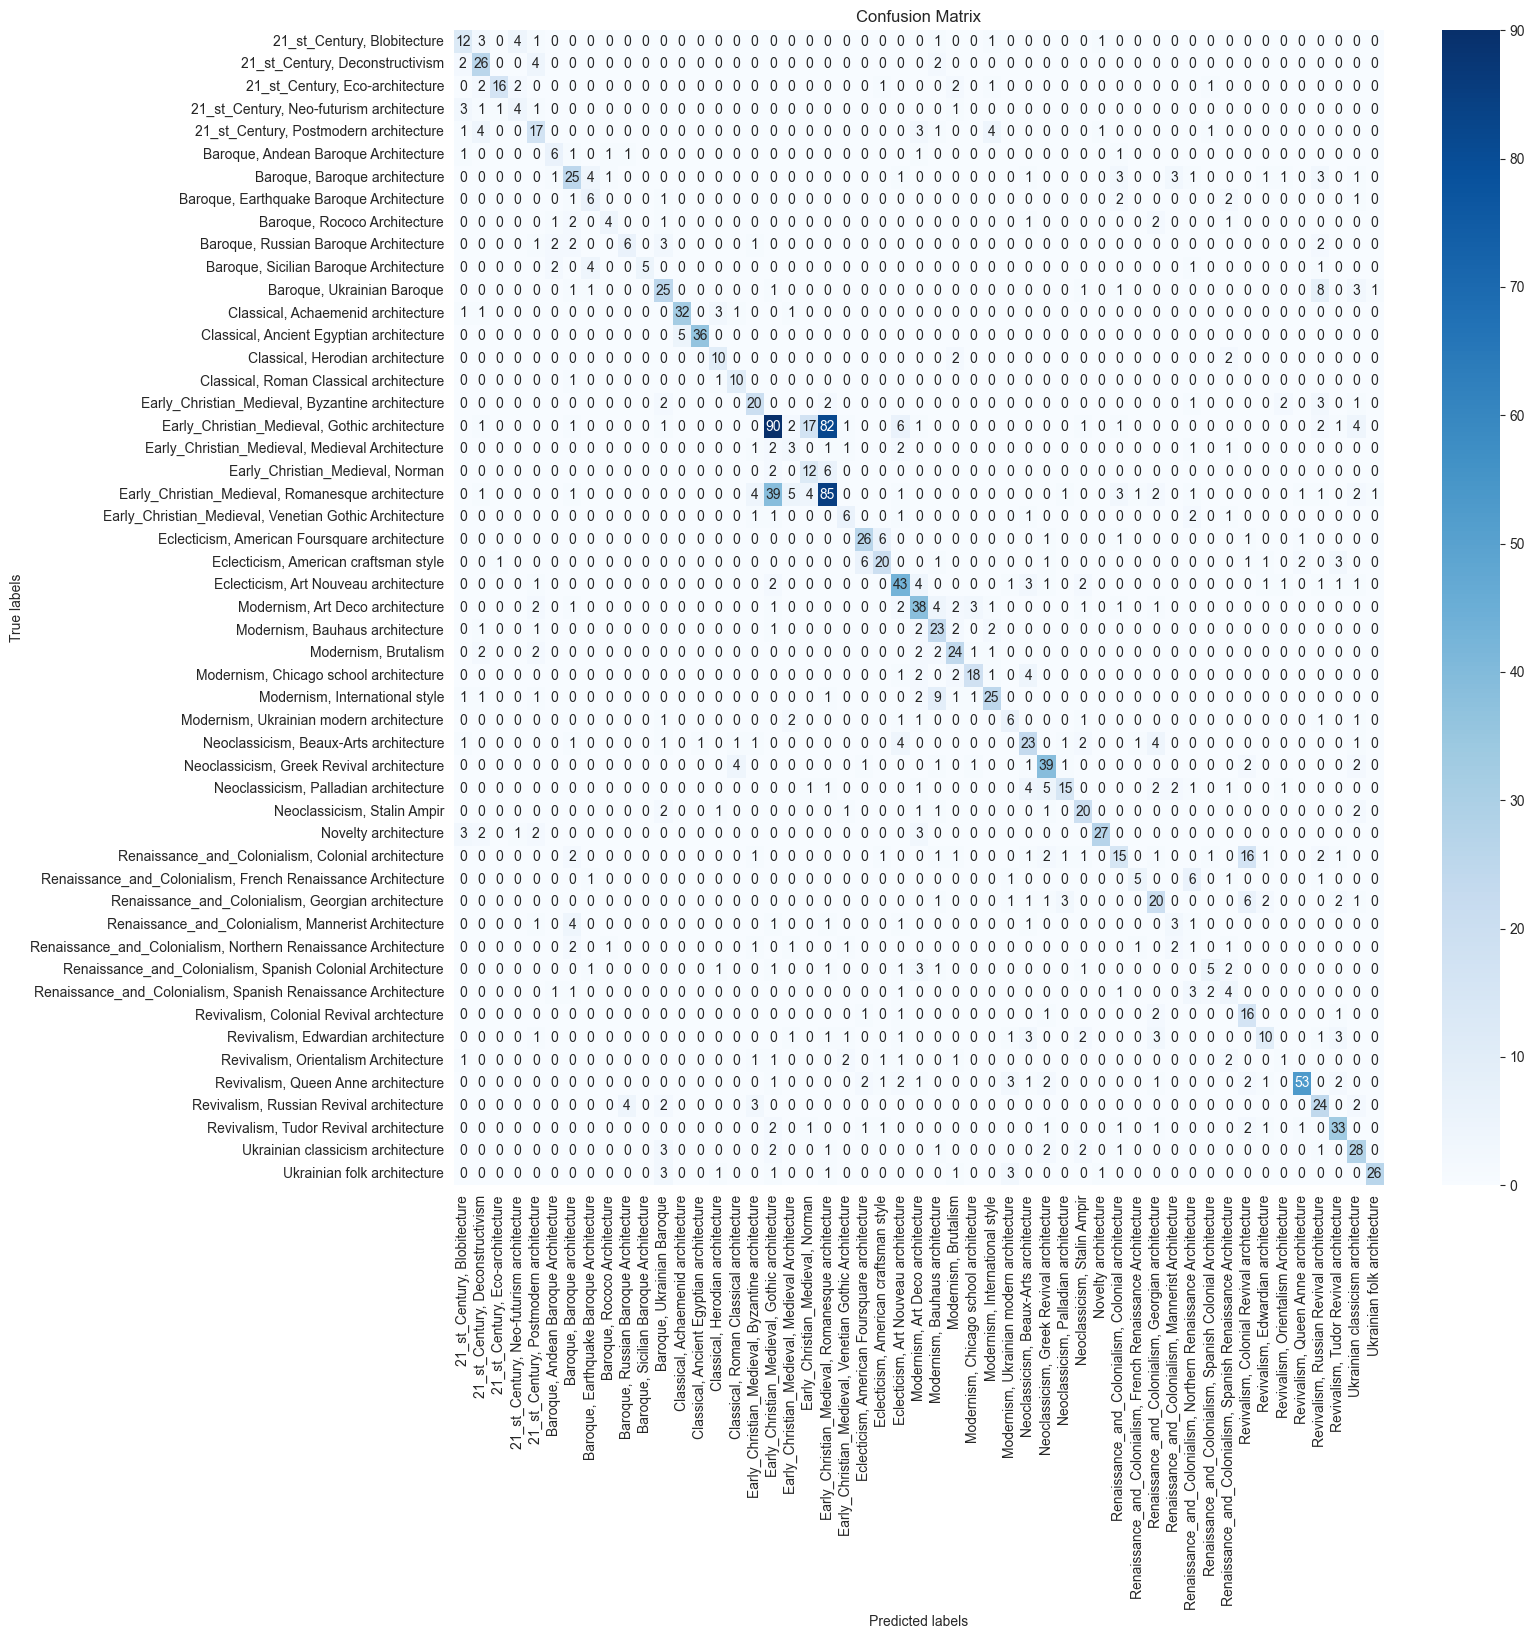

In [24]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
model_name = "model_focal_weighted_v1"
model_json = model2.to_json()
with open(f"{model_name}_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to HDF5 file
model2.save_weights(f"{model_name}.weights.h5")

In [29]:

tf.keras.models.save_model(model2, f"{model_name}.keras")

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

with open('models/model_focal_weighted_v1.tflite', 'wb') as f:
    f.write(tflite_model)

AttributeError: 'Functional' object has no attribute '_get_save_spec'

In [31]:
for epoch, history in enumerate(acc):
    task.get_logger().report_scalar("training", "accuracy", history, iteration=epoch)
for epoch, history in enumerate(val_loss):
    task.get_logger().report_scalar("validation", "loss", history, iteration=epoch)
for epoch, history in enumerate(val_acc):
    task.get_logger().report_scalar("validation", "accuracy", history, iteration=epoch)

In [32]:
task.upload_artifact(artifact_object="model_focal_weighted_v1.keras", name="focal")

True

In [33]:
task.upload_artifact(artifact_object="model_focal_weighted_v1_architecture.json", name="focal_architecture")

True

In [34]:
task.upload_artifact(artifact_object="model_focal_weighted_v1.weights.h5", name="focal_weights")

True